## Task
Estimate benzene (C<sub>6</sub>H<sub>6</sub>) concentration from sensor readings.

In [2]:
# import dependencies

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy

## Data Collection
First, as with any typical machine learning task, we load the dataset that we will use to train our model and test it.

In this case, we will import the [air quality dataset](https://archive.ics.uci.edu/dataset/360/air+quality) from the UCI Machine Learning Repository containing hourly response averages of a gas multisensor device along with references from a certified analyzer, both deployed on the field in an Italian city.

The dataset is loaded from a CSV file, where the format is such that the delimiter/separator of each column is a semicolon instead of a comma, and decimal points for float values are instead substituted with commas. Additionally, there are two redundant columns, and several redundant rows at the ends.

Missing values are flagged with -200.

In [3]:
def load_air_quality_data():
  """
  Load air quality data from csv file

  Returns:
    Dataframe: Table containing raw air quality data
  """

  DATA_SOURCE_FILE_PATH = "AirQualityUCI.csv"

  # each part in a row is delimited by a semicolon ;
  # decimals are represented from commas ,
  raw_data = pd.read_csv(
      filepath_or_buffer=DATA_SOURCE_FILE_PATH,
      delimiter=";",
      decimal=",",
  )

  return raw_data

In [4]:
raw_air_quality_data = load_air_quality_data()

As expected, the last two columns are empty.

## Initial Data Cleaning
Right after loading the dataset, we need to ensure that it does not contain any empty rows and features. Moreover, we will convert each occurrence of the missing flag -200 to NaN for standard representation and handling of missing values.

In [5]:
raw_air_quality_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(15), object(2)
memory usage: 1.2+ MB


As expected, the last two columns are empty, so we drop them.

In [6]:
raw_air_quality_data = raw_air_quality_data.drop(columns=["Unnamed: 15", "Unnamed: 16"])

raw_air_quality_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
dtypes: float64(13), object(2)
memory usage: 1.1+ MB


In [7]:
def count_null_rows(df):
  """
  Counts the number of rows containing empty values in all columns

  Args:
    df (Dataframe): dataset that may contain zero or more null rows

  Returns:
    int: number of null rows
  """


  null_values = df.isna()
  null_rows = null_values.all(axis=1)
  null_row_count = null_rows.sum()

  return null_row_count

print("Number of null rows: ", count_null_rows(raw_air_quality_data))

Number of null rows:  114


There are 114 examples where all the features are NaN. Since they are useless, we drop them.

In [8]:
raw_air_quality_data = raw_air_quality_data.dropna(how="all")

print("Number of null rows: ", count_null_rows(raw_air_quality_data))

Number of null rows:  0


In [9]:
MISSING_FLAG = -200

print(f"Counts of missing value ({MISSING_FLAG}) per column: ")
print(raw_air_quality_data[raw_air_quality_data == MISSING_FLAG].count())

Counts of missing value (-200) per column: 
Date                0
Time                0
CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64


All features, except the temporal ones, contain missing values. We will replace the occurrences of the flag to NaN as it is the standard way to represent missing values.

In [10]:
air_quality_data = raw_air_quality_data.replace(to_replace=MISSING_FLAG, value=np.nan)

air_quality_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         7674 non-null   float64
 3   PT08.S1(CO)    8991 non-null   float64
 4   NMHC(GT)       914 non-null    float64
 5   C6H6(GT)       8991 non-null   float64
 6   PT08.S2(NMHC)  8991 non-null   float64
 7   NOx(GT)        7718 non-null   float64
 8   PT08.S3(NOx)   8991 non-null   float64
 9   NO2(GT)        7715 non-null   float64
 10  PT08.S4(NO2)   8991 non-null   float64
 11  PT08.S5(O3)    8991 non-null   float64
 12  T              8991 non-null   float64
 13  RH             8991 non-null   float64
 14  AH             8991 non-null   float64
dtypes: float64(13), object(2)
memory usage: 1.1+ MB


Notice that the label column C6H6(GT) has some null values. We ought not to perform any imputation on the ground truth, as doing so is equivalent to learning misinformation. Hence, we drop the examples where the C6H6(GT) is missing.

In [11]:
final_air_quality_data = air_quality_data.dropna(
    axis=0, subset=["C6H6(GT)"]
  ).reset_index(
  ).drop(columns="index")

air_quality_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         7674 non-null   float64
 3   PT08.S1(CO)    8991 non-null   float64
 4   NMHC(GT)       914 non-null    float64
 5   C6H6(GT)       8991 non-null   float64
 6   PT08.S2(NMHC)  8991 non-null   float64
 7   NOx(GT)        7718 non-null   float64
 8   PT08.S3(NOx)   8991 non-null   float64
 9   NO2(GT)        7715 non-null   float64
 10  PT08.S4(NO2)   8991 non-null   float64
 11  PT08.S5(O3)    8991 non-null   float64
 12  T              8991 non-null   float64
 13  RH             8991 non-null   float64
 14  AH             8991 non-null   float64
dtypes: float64(13), object(2)
memory usage: 1.1+ MB


## Splitting Dataset
Before any further data preprocessing, we must split the dataset into the training set and the test set. We will build a preprocessing pipeline based on our exploration and analysis of the training set. Doing it separately makes sure that information from test dataset does not leak into our training process.

The splitting strategy simply chooses the first 75% of the observations for training, and the remanining 25% will form the test set.

In [12]:
training_size = int(len(final_air_quality_data) * 0.75)

training_set = final_air_quality_data[:training_size]
test_set = final_air_quality_data[training_size:]

print(f"Size of training set: {len(training_set)}")
print(f"Size of test set: {len(test_set)}")

Size of training set: 6743
Size of test set: 2248


In [13]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6743 entries, 0 to 6742
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           6743 non-null   object 
 1   Time           6743 non-null   object 
 2   CO(GT)         5288 non-null   float64
 3   PT08.S1(CO)    6743 non-null   float64
 4   NMHC(GT)       887 non-null    float64
 5   C6H6(GT)       6743 non-null   float64
 6   PT08.S2(NMHC)  6743 non-null   float64
 7   NOx(GT)        5314 non-null   float64
 8   PT08.S3(NOx)   6743 non-null   float64
 9   NO2(GT)        5311 non-null   float64
 10  PT08.S4(NO2)   6743 non-null   float64
 11  PT08.S5(O3)    6743 non-null   float64
 12  T              6743 non-null   float64
 13  RH             6743 non-null   float64
 14  AH             6743 non-null   float64
dtypes: float64(13), object(2)
memory usage: 790.3+ KB


## Feature Selection

For a learning algorithm to learn from the training data effectively, it is important that we select the features relevant to our task.

Before we begin the process of selecting the features, let's separate the target variable from the features.

In [14]:
label_name = "C6H6(GT)"
labels = copy.deepcopy(training_set[label_name])

features = training_set.drop(columns=label_name)

selected_features = features.columns.values.tolist()
selected_features

['Date',
 'Time',
 'CO(GT)',
 'PT08.S1(CO)',
 'NMHC(GT)',
 'PT08.S2(NMHC)',
 'NOx(GT)',
 'PT08.S3(NOx)',
 'NO2(GT)',
 'PT08.S4(NO2)',
 'PT08.S5(O3)',
 'T',
 'RH',
 'AH']

Firstly, since we are not explicitly forecasting future trends of benzene concentration, temporal features will not be useful here.

In [15]:
temporal_features = ['Date', 'Time']

for feature in temporal_features:
  selected_features.remove(feature)

selected_features

['CO(GT)',
 'PT08.S1(CO)',
 'NMHC(GT)',
 'PT08.S2(NMHC)',
 'NOx(GT)',
 'PT08.S3(NOx)',
 'NO2(GT)',
 'PT08.S4(NO2)',
 'PT08.S5(O3)',
 'T',
 'RH',
 'AH']

Next, as we will only be relying on sensor data for our prediction, we will eliminate the features providing ground truth references for some of the pollutants.

In [16]:
gt_features = ['CO(GT)', 'NMHC(GT)', 'NOx(GT)', 'NO2(GT)']

for feature in gt_features:
  selected_features.remove(feature)

print(f"Selected features: {selected_features}")

Selected features: ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']


In [17]:
# training_set.corr(method="pearson", numeric_only=True)["C6H6(GT)"].sort_values(ascending=False)

Now that we have selected all of our features, we will create a function for our preprocessing pipeline that returns only the selected features.

In [18]:
def select_features(df):
  """
  Select the features
  """
  return copy.deepcopy(df[selected_features])

In [19]:
reduced_features = select_features(training_set)

## Data Imputation

To handle missing values in our training set, we will perform a mean imputation over each feature as dropping the related examples would otherwise degrade model performance.

Before doing so, we check if there are missing values.

In [20]:
reduced_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6743 entries, 0 to 6742
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PT08.S1(CO)    6743 non-null   float64
 1   PT08.S2(NMHC)  6743 non-null   float64
 2   PT08.S3(NOx)   6743 non-null   float64
 3   PT08.S4(NO2)   6743 non-null   float64
 4   PT08.S5(O3)    6743 non-null   float64
 5   T              6743 non-null   float64
 6   RH             6743 non-null   float64
 7   AH             6743 non-null   float64
dtypes: float64(8)
memory usage: 421.6 KB


While it is apparent that our feature matrix does not contain any missing values, it is best to assume that such is not the case with the test set, so that any possible occurrence of missing value will be replaced by the mean derived from the training set.

In [21]:
means = pd.Series(index=selected_features)

for feature in reduced_features.columns.values:
  feature_mean = reduced_features[feature].mean()
  means[feature] = feature_mean

means

PT08.S1(CO)      1098.877354
PT08.S2(NMHC)     965.079193
PT08.S3(NOx)      855.298977
PT08.S4(NO2)     1561.093579
PT08.S5(O3)      1017.308616
T                  21.067255
RH                 48.082174
AH                  1.147894
dtype: float64

Now, we create a function that performs mean imputation fit to the feature matrix.

In [22]:
def impute(features):
  imputed_features = copy.deepcopy(features)

  for feature in features.columns.values:
    imputed_features[feature].fillna(means[feature])

  return imputed_features

In [23]:
imputed_features = impute(reduced_features)

## Feature Scaling

In order for gradient descent to find the minimum fast, we scale our features using various techniques.

Techniques:
1. Min-max scaling
2. Mean normalization
3. Standardization

In [24]:
from abc import ABC, abstractmethod

class FeatureScaler(ABC):

  @abstractmethod
  def fit(self, features_to_fit):
    pass

  @abstractmethod
  def scale(self, features_to_scale):
    pass

class MinMaxScaler(FeatureScaler):

    def __init__(self):
        self.min_values = None
        self.max_values = None

    def fit(self, features_to_fit):
        self.min_values = features_to_fit.min()
        self.max_values = features_to_fit.max()

    def scale(self, features_to_scale):
        return (features_to_scale - self.min_values) / (self.max_values - self.min_values)

class MeanNormalizer(FeatureScaler):

    def __init__(self):
        self.mean_values = None
        self.min_values = None
        self.max_values = None

    def fit(self, features_to_fit):
        self.mean_values = features_to_fit.mean()
        self.min_values = features_to_fit.min()
        self.max_values = features_to_fit.max()

    def scale(self, features_to_scale):
        return (features_to_scale - self.mean_values) / (self.max_values - self.min_values)

class StandardScaler(FeatureScaler):

    def __init__(self):
        self.mean_values = None
        self.std_values = None

    def fit(self, features_to_fit):
        self.mean_values = features_to_fit.mean()
        self.std_values = features_to_fit.std()

    def scale(self, features_to_scale):
        return (features_to_scale - self.mean_values) / self.std_values

In [25]:
def instantiate_scalers(features_to_fit):
  min_max_scaler = MinMaxScaler()
  min_max_scaler.fit(features_to_fit)

  mean_normalizer = MeanNormalizer()
  mean_normalizer.fit(features_to_fit)

  standard_scaler = StandardScaler()
  standard_scaler.fit(features_to_fit)

  return dict(
      minmax=min_max_scaler,
      norm=mean_normalizer,
      standard=standard_scaler,
    )

scalers = instantiate_scalers(imputed_features)

In [26]:
def get_scaling_function(scaler_choice="minmax"):
  def scale(features_to_scale):
    return scalers[scaler_choice].scale(features_to_scale)

  return scale

scaled_features = {
    scaler_choice: get_scaling_function(scaler_choice)(imputed_features) for scaler_choice in scalers.keys()
}

In [27]:
scaled_features['minmax']

PT08.S1(CO)  PT08.S2(NMHC)  PT08.S3(NOx)  PT08.S4(NO2)  PT08.S5(O3)  \
0        0.511845       0.357182      0.310885      0.482561     0.445181   
1        0.463029       0.307100      0.360864      0.419016     0.314324   
2        0.541996       0.298294      0.346463      0.417105     0.359416   
3        0.523331       0.303247      0.326133      0.430960     0.416446   
4        0.448672       0.241607      0.373994      0.386049     0.375332   
...           ...            ...           ...           ...          ...   
6738     0.447954       0.269125      0.155019      0.305303     0.376658   
6739     0.368988       0.227298      0.191868      0.286192     0.308134   
6740     0.291457       0.155751      0.240576      0.231247     0.241379   
6741     0.193108       0.079252      0.347734      0.182513     0.121574   
6742     0.181622       0.068795      0.389665      0.185380     0.092838   

             T        RH        AH  
0     0.285714  0.499371  0.275071  
1     0.278802  0.484277  0.259177  
2     0.246544  0.563522  0.271332  
3     0.225806  0.638994  0.289292  
4     0.230415  0.633962  0.290326  
...        ...       ...       ...  
6738  0.241935  0.888050  0.441689  
6739  0.239631  0.890566  0.439720  
6740  0.232719  0.891824  0.430715  
6741  0.241935  0.816352  0.402470  
6742  0.221198  0.874214  0.404193  

[6743 rows x 8 columns]

In [28]:
scaled_features['norm']

PT08.S1(CO)  PT08.S2(NMHC)  PT08.S3(NOx)  PT08.S4(NO2)  PT08.S5(O3)  \
0        0.187453       0.044535      0.085007      0.062545     0.110827   
1        0.138638      -0.005547      0.134986     -0.001000    -0.020030   
2        0.217604      -0.014353      0.120585     -0.002911     0.025063   
3        0.198939      -0.009400      0.100255      0.010944     0.082092   
4        0.124280      -0.071040      0.148116     -0.033967     0.040978   
...           ...            ...           ...           ...          ...   
6738     0.123563      -0.043522     -0.070859     -0.114713     0.042304   
6739     0.044596      -0.085349     -0.034011     -0.133824    -0.026220   
6740    -0.032934      -0.156896      0.014698     -0.188769    -0.092975   
6741    -0.131283      -0.233395      0.121856     -0.237503    -0.212780   
6742    -0.142769      -0.243852      0.163787     -0.234636    -0.241516   

             T        RH        AH  
0    -0.172057  0.010287 -0.191957  
1    -0.178969 -0.004807 -0.207851  
2    -0.211227  0.074438 -0.195696  
3    -0.231964  0.149910 -0.177736  
4    -0.227356  0.144878 -0.176702  
...        ...       ...       ...  
6738 -0.215835  0.398966 -0.025339  
6739 -0.218140  0.401482 -0.027307  
6740 -0.225052  0.402740 -0.036312  
6741 -0.215835  0.327268 -0.064558  
6742 -0.236573  0.385130 -0.062835  

[6743 rows x 8 columns]

In [29]:
scaled_features['standard']

PT08.S1(CO)  PT08.S2(NMHC)  PT08.S3(NOx)  PT08.S4(NO2)  PT08.S5(O3)  \
0        1.183016       0.303863      0.772057      0.430749     0.650899   
1        0.874942      -0.037848      1.225979     -0.006889    -0.117640   
2        1.373297      -0.097929      1.095188     -0.020051     0.147194   
3        1.255504      -0.064133      0.910542      0.075374     0.482132   
4        0.784332      -0.484701      1.345230     -0.233934     0.240665   
...           ...            ...           ...           ...          ...   
6738     0.779801      -0.296947     -0.643566     -0.790030     0.248455   
6739     0.281447      -0.582332     -0.308894     -0.921651    -0.153990   
6740    -0.207847      -1.070491      0.133488     -1.300059    -0.546049   
6741    -0.828526      -1.592445      1.106729     -1.635691    -1.249678   
6742    -0.901014      -1.663791      1.487562     -1.615948    -1.418445   

             T        RH        AH  
0    -0.937333  0.046922 -1.057552  
1    -0.974991 -0.021927 -1.145118  
2    -1.150727  0.339531 -1.078156  
3    -1.263700  0.683776 -0.979204  
4    -1.238595  0.660826 -0.973511  
...        ...       ...       ...  
6738 -1.175832  1.819786 -0.139602  
6739 -1.188385  1.831261 -0.150446  
6740 -1.226042  1.836998 -0.200057  
6741 -1.175832  1.492753 -0.355670  
6742 -1.288805  1.756674 -0.346181  

[6743 rows x 8 columns]

We will test our gradient descent algorithm for each scaled matrix to check which performs best.

## Preprocessing Pipeline

We can now set up a pipeline that will preprocess any future input in the same way we preprocessed the training set.

In [30]:
def preprocess_data(input, scaler_choice="norm"):
  input = select_features(input)

  input = impute(input)

  preprocessed_input = get_scaling_function(scaler_choice)(input)

  return preprocessed_input

## Training

Now comes the most important part: fitting a multivariate linear regression model to our training dataset using batch gradient descent.
We train several models differentiated by:
- the scaling technique applied to their training set, and
- the learning rate used to train it.

We will select the model that scores the lowest MSE.

Let's define all the necessary functions and values.

In [31]:
def compute_hypothesis(X, theta):
  return X @ theta

In [32]:
def compute_mse(theta, X, y_true):
  n_samples = len(X)

  predictions = compute_hypothesis(X, theta)
  error = predictions - y_true

  return 1 / (2 * n_samples) * np.sum(error ** 2)

def compute_gradient(theta, X, y_true):
  n_samples = len(X)

  predictions = compute_hypothesis(X, theta)
  error = predictions - y_true

  return (1 / n_samples) * (X.T @ error)

In [33]:
import math

class TrainingResult:
  def __init__(self, theta, alpha, cost_history, iters):
    self.theta = theta
    self.alpha = alpha
    self.cost_history = cost_history
    self.iters = iters

  def __str__(self):
    return (
        f"Parameters = {self.theta}\n"
      + f"Learning rate = {self.alpha}\n"
      + f"Iterations = {self.iters}\n"
      + f"Last cost = {self.cost_history[-1]}"
    )

  def __repr__(self):
    return self.__str__()

def run_gradient_descent(theta_in, X_train, y_train, alpha=0.001, max_iters=100000):

  # Deep copy to avoid modifying input theta
  theta = copy.deepcopy(theta_in)

  cost_history = []
  current_cost = compute_mse(theta, X_train, y_train)

  for i in range(max_iters):
    theta = theta - alpha * compute_gradient(theta, X_train, y_train)

    previous_cost = current_cost
    current_cost = compute_mse(theta, X_train, y_train)

    if i < 100000:
      cost_history.append(current_cost)

    if i % math.ceil(max_iters / 20) == 0:
      print(f"iteration: {i}; cost: {current_cost: 0.2e}")

    if abs(previous_cost - current_cost) < 1e-3 or current_cost > 1e10:
      return TrainingResult(
          theta=theta, iters=i, cost_history=cost_history, alpha=alpha
      )

  return TrainingResult(
          theta=theta, iters=max_iters, cost_history=cost_history, alpha=alpha
      )

In [34]:
LEARNING_RATES = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]

Below are some utility functions for preparing training data.

In [35]:
def prepend_column_of_ones(matrix):
  column_of_ones = np.repeat([[1]], len(matrix), axis=0)

  return np.hstack((column_of_ones, matrix))

def get_X(features):
  np_features = np.array(features)

  return prepend_column_of_ones(np_features)

In [36]:
def get_y(labels):
  return np.array(labels)

In [37]:
def initialize_parameters(n_features):
  return np.zeros(n_features + 1)

Plotting functions:

In [38]:
def plot_cost_vs_iteration(cost_history, iters, alpha):
  fig, (ax1) = plt.subplots(1, 1, constrained_layout=True, figsize=(12,4))
  ax1.plot(cost_history[:iters])
  ax1.set_title(r"Cost vs. Iteration ($\alpha$=" + str(alpha) + ")");
  ax1.set_ylabel('Cost')
  ax1.set_xlabel('Iteration')

  plt.show()

In [39]:
def scatter_ytrue_vs_ypred_over_features(y_true, y_pred, X, label_name, feature_names):
  features = X[:, 1:]
  n_features = features.shape[1]

  # Create a figure with subplots for each feature
  rows = n_features // 2
  cols = 2
  fig, axes = plt.subplots(rows, cols, figsize=(8 * cols, 6 * rows), constrained_layout=True)
  fig.set_constrained_layout_pads(wspace=0.1, hspace=0.1)
  fig.suptitle('True vs. Predicted Using Z-Score Normalized Model')

  for feature_index in range(n_features):
    i = feature_index // 2
    j = feature_index % 2
    ax = axes[i, j]

    ax.set_xlabel(feature_names[i])
    ax.set_ylabel(label_name)

    ax.scatter(
        features[:, feature_index], y_pred, color="darkorange",
        marker="o", label='Predicted', alpha=0.3, zorder=2,
    )
    ax.scatter(
        features[:, feature_index], y_true, color="green",
        marker="o", label='True', alpha=0.5, zorder=1,
    )
    ax.legend()

Lastly, to make training over various learning rates procedural:

In [40]:
def train_over_alphas(X_train, y_train, alphas):
  training_results = []

  theta_in = np.zeros(X_train.shape[1])
  best_result = None

  for alpha in alphas:

    current_result = run_gradient_descent(
        theta_in=theta_in,
        X_train=X_train,
        y_train=y_train,
        alpha=alpha,
    )

    if best_result is None or current_result.cost_history[-1] < best_result.cost_history[-1]:
      best_result = current_result

    training_results.append(current_result)

  return training_results, best_result

### Training over Min-Maxed Features

iteration: 0; cost:  8.65e+01
iteration: 5000; cost:  1.20e+01
iteration: 0; cost:  8.59e+01
iteration: 0; cost:  8.39e+01
iteration: 0; cost:  7.84e+01
iteration: 0; cost:  6.10e+01
iteration: 0; cost:  2.88e+01
iteration: 0; cost:  1.18e+02


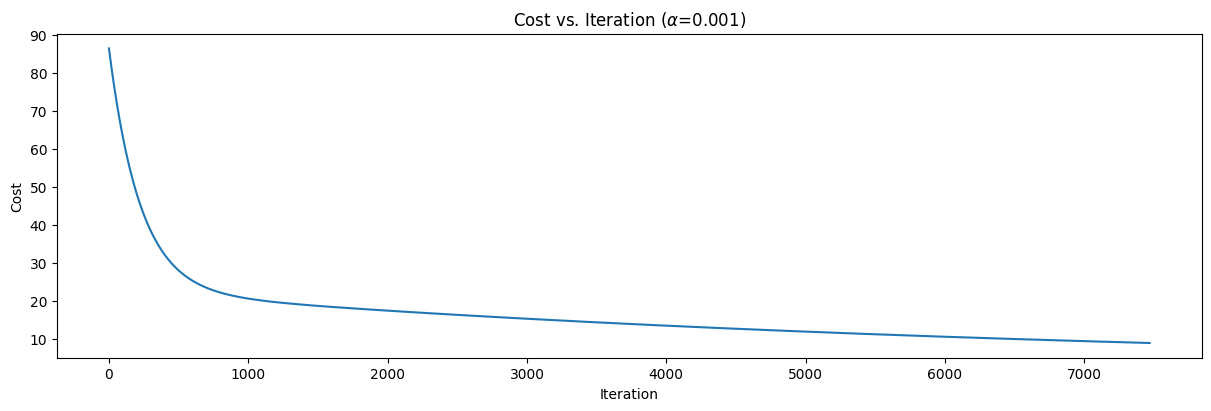

Parameters = [ 2.24983497  6.00130031  6.31335753 -2.48705397  5.11855387  6.45799027
  1.49078669  0.16818021  0.70209278]
Learning rate = 0.001
Iterations = 7470
Last cost = 8.99153346764618


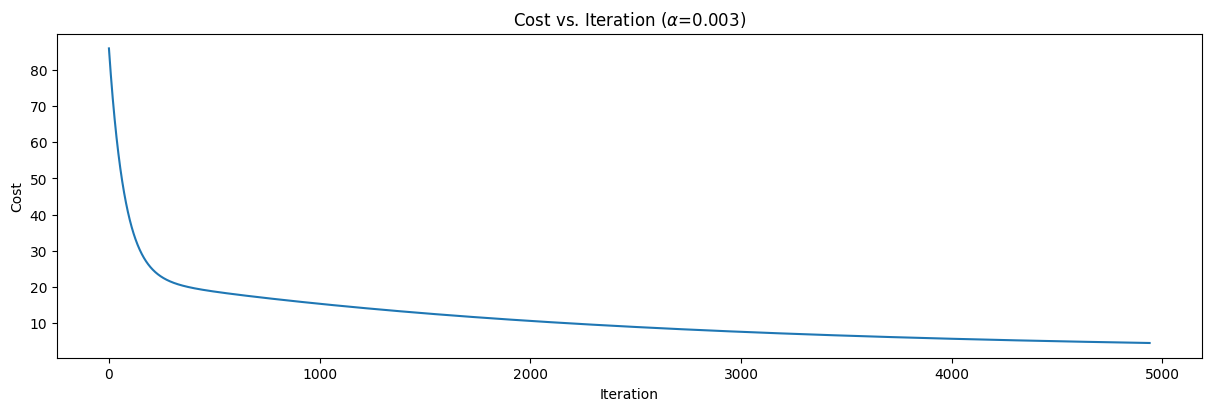

Parameters = [ 0.73941699  8.36748543  9.11014924 -4.36745555  6.78854456  9.06601383
  0.89875224 -1.0734708  -0.41542778]
Learning rate = 0.003
Iterations = 4941
Last cost = 4.5351895161634745


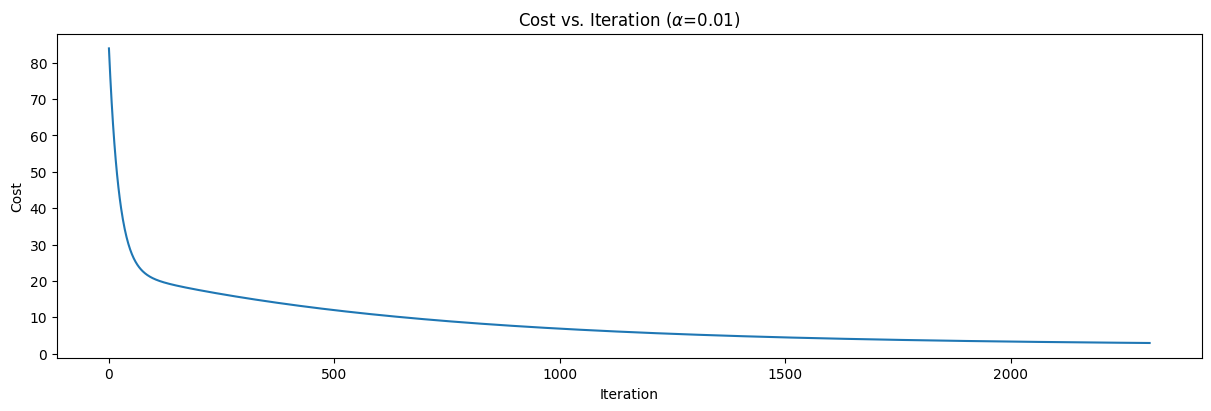

Parameters = [-0.178233    9.78211629 11.05002872 -5.41667521  7.86720466 10.6447365
  0.43342554 -1.81390156 -1.24865477]
Learning rate = 0.01
Iterations = 2309
Last cost = 2.938441690448813


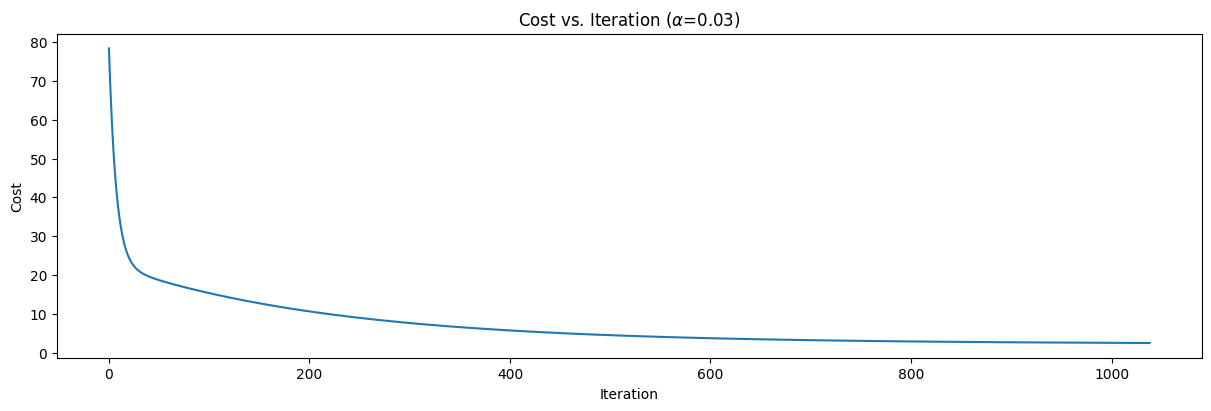

Parameters = [-0.65127608 10.45840188 12.26375134 -5.85583981  8.4769859  11.41917238
  0.12107115 -2.18605812 -1.79078264]
Learning rate = 0.03
Iterations = 1039
Last cost = 2.4515136729048534


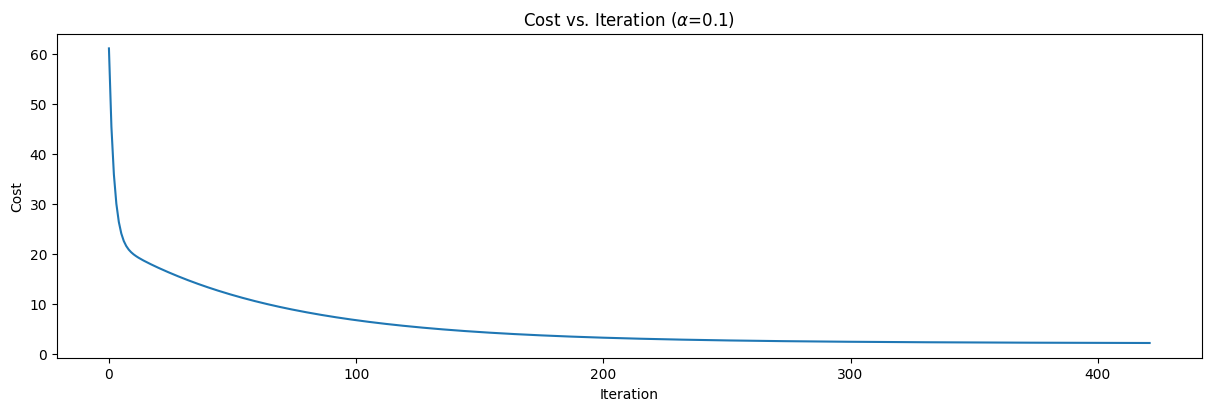

Parameters = [-0.97423623 10.80459328 13.36290261 -5.99798025  8.95413006 11.84802809
 -0.16014754 -2.42254252 -2.26828904]
Learning rate = 0.1
Iterations = 422
Last cost = 2.2442024349098766


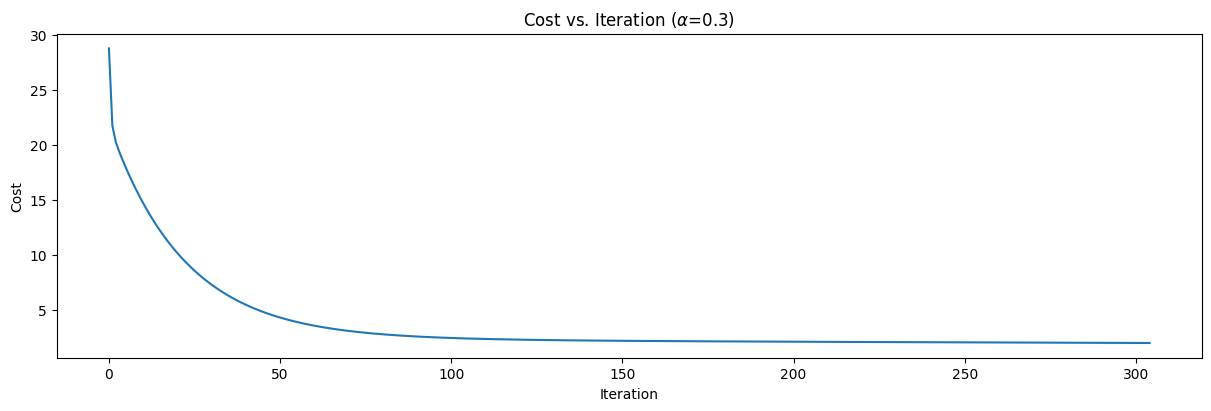

Parameters = [-1.45948777 10.2267245  16.10891079 -5.19283711  9.76488484 11.46150898
 -0.64826202 -2.50516287 -2.96662447]
Learning rate = 0.3
Iterations = 305
Last cost = 2.0175355613713895


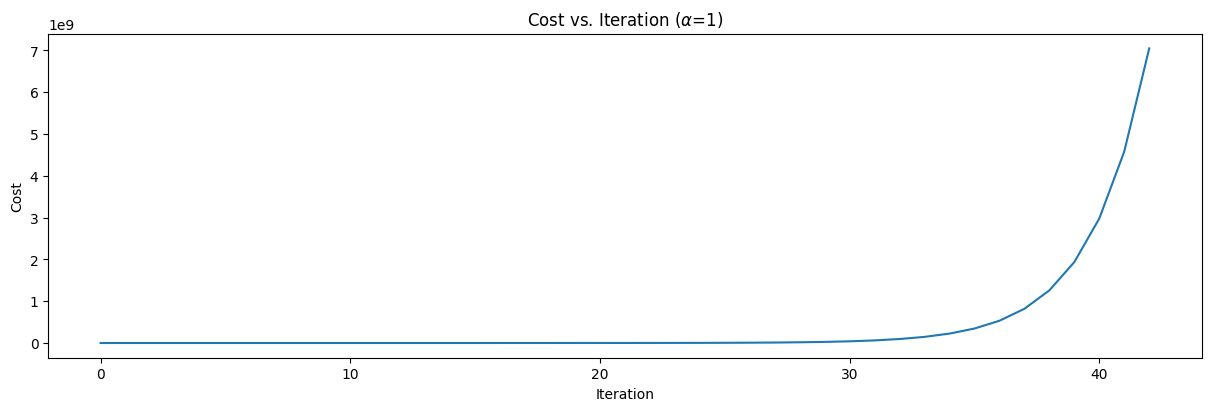

Parameters = [-65264.56326061 -22089.1702034  -21214.47009589 -14113.24658851
 -28398.55952862 -22739.13992239 -30294.26748578 -32394.11815103
 -31484.5800027 ]
Learning rate = 1
Iterations = 43
Last cost = 10842954134.877014


In [41]:
minmax_training_results, best_result = train_over_alphas(
    X_train=get_X(scaled_features["minmax"]),
    y_train=get_y(labels),
    alphas=LEARNING_RATES
)

best_results = { "minmax": best_result }

for res in minmax_training_results:
  plot_cost_vs_iteration(cost_history=res.cost_history, iters=res.iters, alpha=res.alpha)
  print(res)

In [42]:
print(best_results["minmax"])

Parameters = [-1.45948777 10.2267245  16.10891079 -5.19283711  9.76488484 11.46150898
 -0.64826202 -2.50516287 -2.96662447]
Learning rate = 0.3
Iterations = 305
Last cost = 2.0175355613713895


### Training over Mean-Normalized Features

iteration: 0; cost:  8.67e+01
iteration: 5000; cost:  1.31e+01
iteration: 0; cost:  8.64e+01
iteration: 0; cost:  8.56e+01
iteration: 0; cost:  8.32e+01
iteration: 0; cost:  7.53e+01
iteration: 0; cost:  5.59e+01
iteration: 0; cost:  2.44e+01


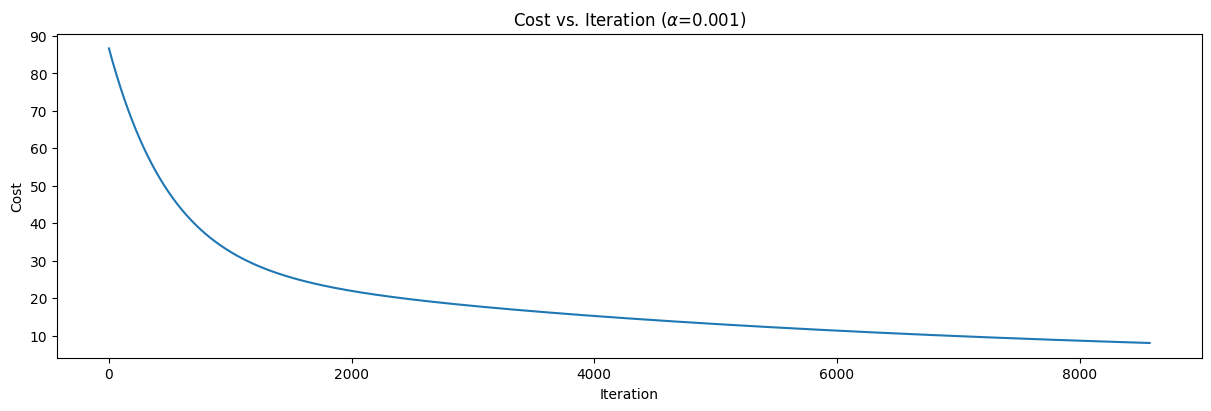

Parameters = [10.73730637  6.3264173   6.65488883 -3.64094869  5.18688411  6.79787531
  0.74935284 -0.69812204  0.24008822]
Learning rate = 0.001
Iterations = 8579
Last cost = 8.014314825457355


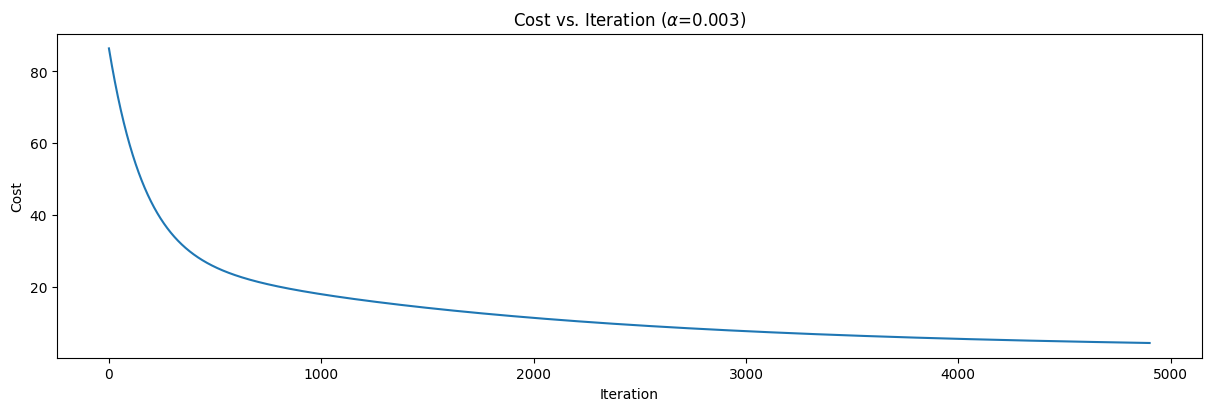

Parameters = [10.73931055  8.53941742  9.21402627 -4.81255698  6.98569602  9.20787723
  0.81395253 -1.07699281 -0.09462654]
Learning rate = 0.003
Iterations = 4902
Last cost = 4.311212591159868


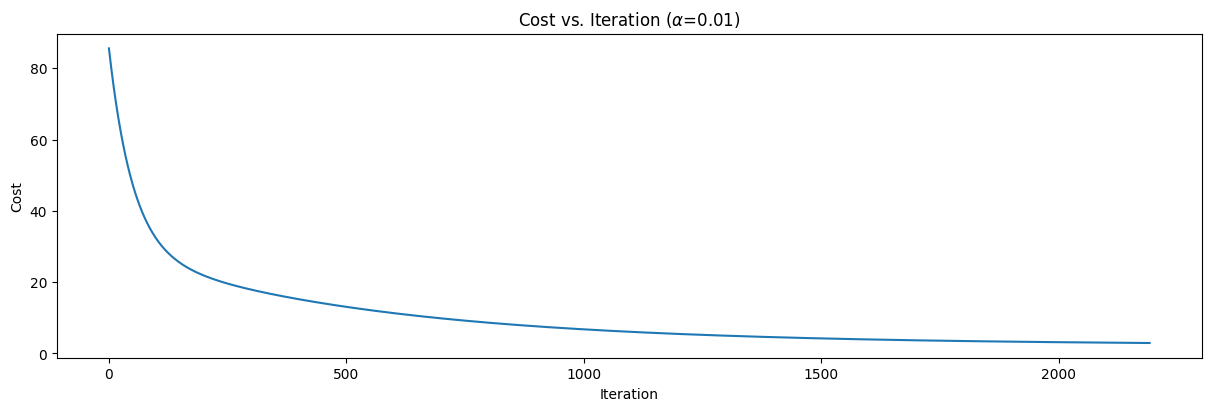

Parameters = [10.73931484  9.91171213 11.05040044 -5.44864869  8.12076786 10.73123754
  0.70453319 -1.42285128 -0.63313266]
Learning rate = 0.01
Iterations = 2192
Last cost = 2.926334123083962


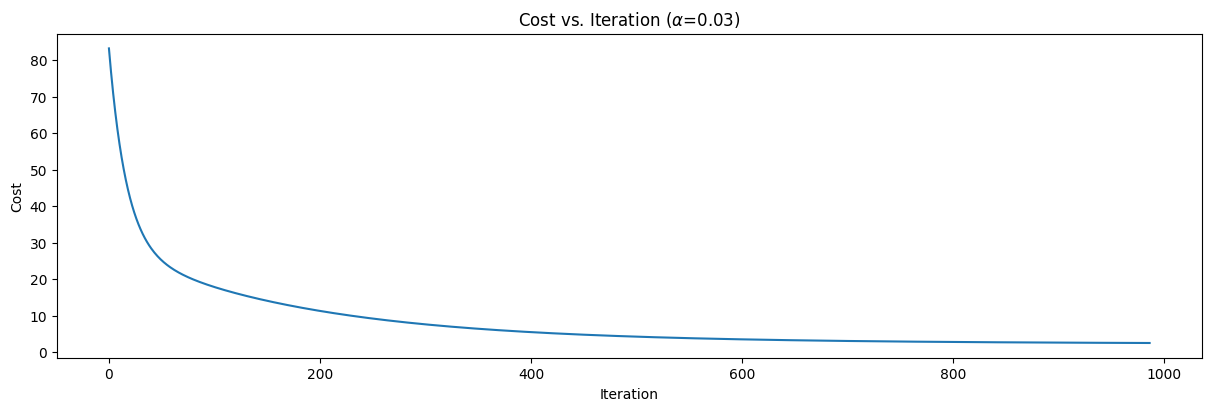

Parameters = [10.73931485 10.59964192 12.265307   -5.67652376  8.74101208 11.52492966
  0.5216106  -1.69601137 -1.19681609]
Learning rate = 0.03
Iterations = 987
Last cost = 2.4677043086893824


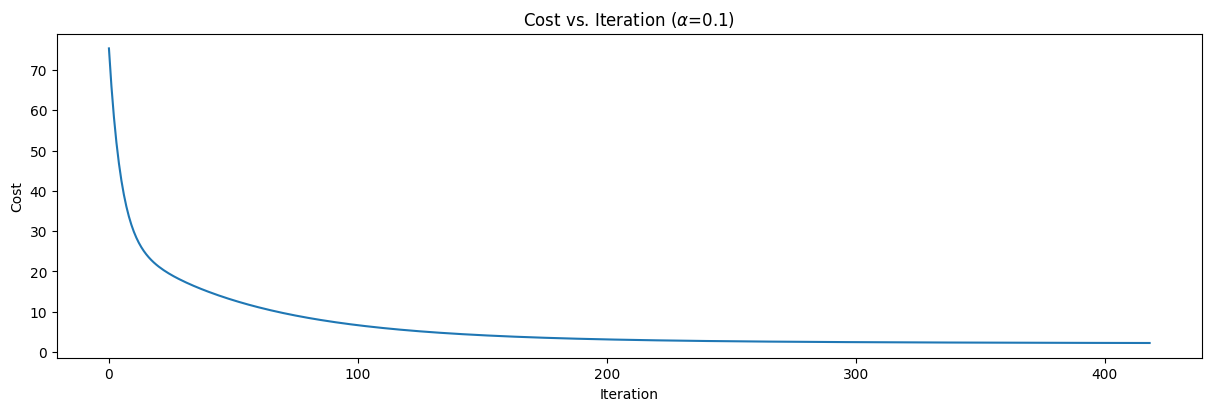

Parameters = [10.73931485 10.94454973 13.47639515 -5.63146434  9.20158479 11.97855589
  0.24537316 -1.97911038 -1.91667897]
Learning rate = 0.1
Iterations = 419
Last cost = 2.24208695924506


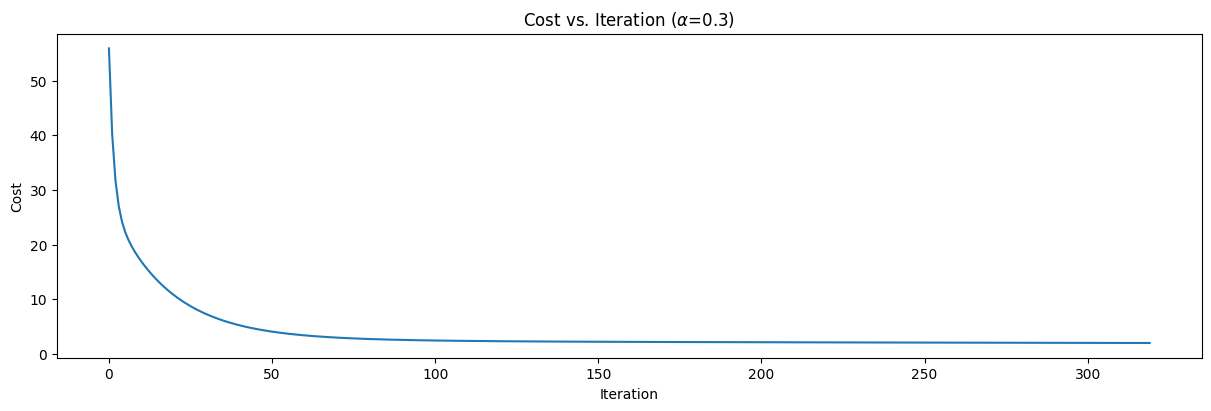

Parameters = [10.73931485 10.21425904 16.45083409 -4.50613773  9.89950487 11.51599707
 -0.26579289 -2.17297534 -3.02779627]
Learning rate = 0.3
Iterations = 320
Last cost = 1.9851304634636442


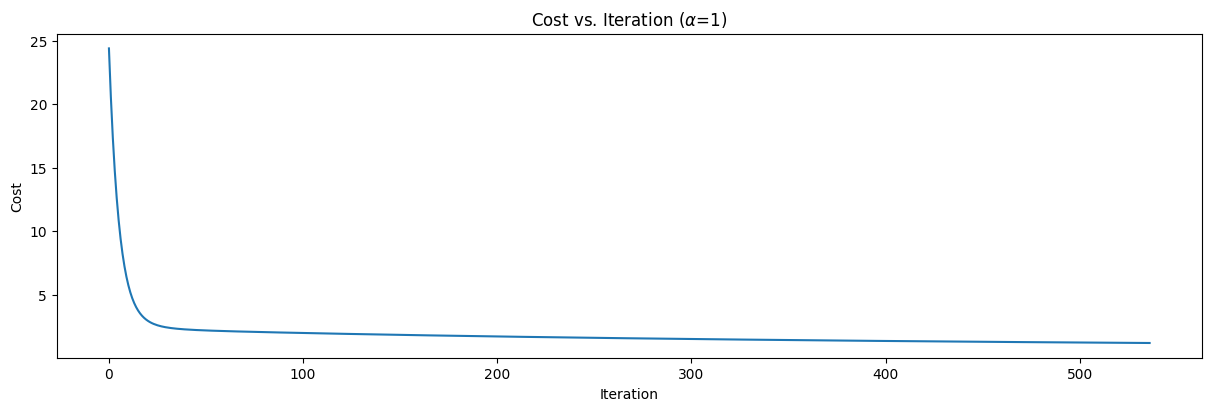

Parameters = [10.73931485  3.86538014 32.02175567  1.7345238   9.66058462  7.46946631
 -0.77685132 -0.73931114 -2.36355227]
Learning rate = 1
Iterations = 537
Last cost = 1.1803879170115466


In [43]:
norm_training_results, best_result = train_over_alphas(
    X_train=get_X(scaled_features["norm"]),
    y_train=get_y(labels),
    alphas=LEARNING_RATES
)

best_results["norm"] = best_result

for res in norm_training_results:
  plot_cost_vs_iteration(cost_history=res.cost_history, iters=res.iters, alpha=res.alpha)
  print(res)

In [44]:
best_results["norm"]

Parameters = [10.73931485  3.86538014 32.02175567  1.7345238   9.66058462  7.46946631
 -0.77685132 -0.73931114 -2.36355227]
Learning rate = 1
Iterations = 537
Last cost = 1.1803879170115466

### Training over Z-Standardized Features

iteration: 0; cost:  8.64e+01
iteration: 0; cost:  8.58e+01
iteration: 0; cost:  8.35e+01
iteration: 0; cost:  7.72e+01
iteration: 0; cost:  5.84e+01
iteration: 0; cost:  3.34e+01
iteration: 0; cost:  2.78e+02


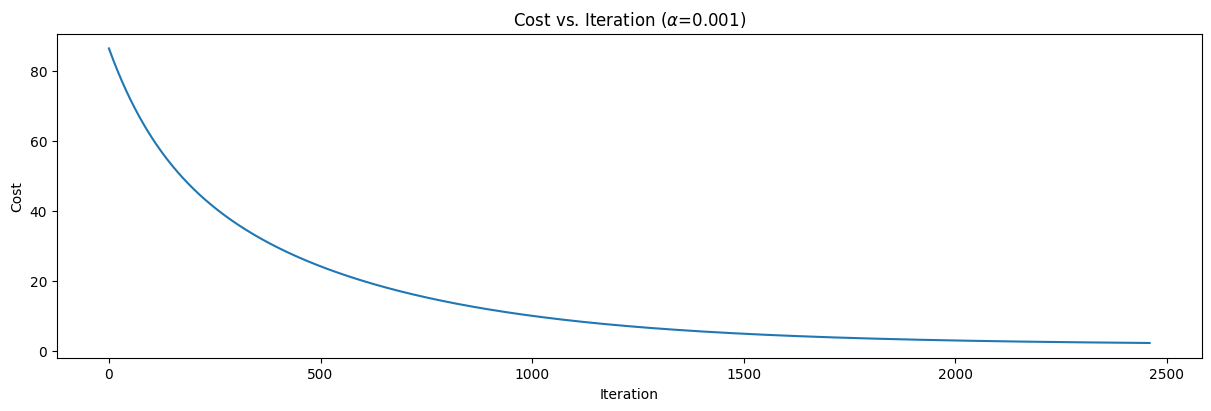

Parameters = [ 9.82384699  1.50496809  2.6473934  -0.6598948   1.51823135  1.6175076
 -0.0775873  -0.39244005 -0.62621985]
Learning rate = 0.001
Iterations = 2460
Last cost = 2.320166350852581


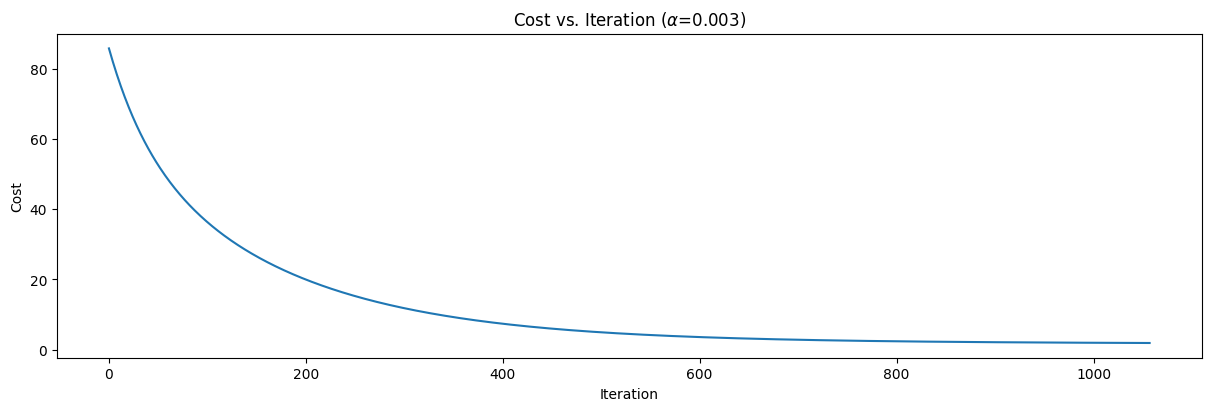

Parameters = [10.29350544  1.43221548  2.86147603 -0.51581987  1.54937127  1.58487416
 -0.08930787 -0.38518929 -0.6385319 ]
Learning rate = 0.003
Iterations = 1058
Last cost = 1.8965984670250935


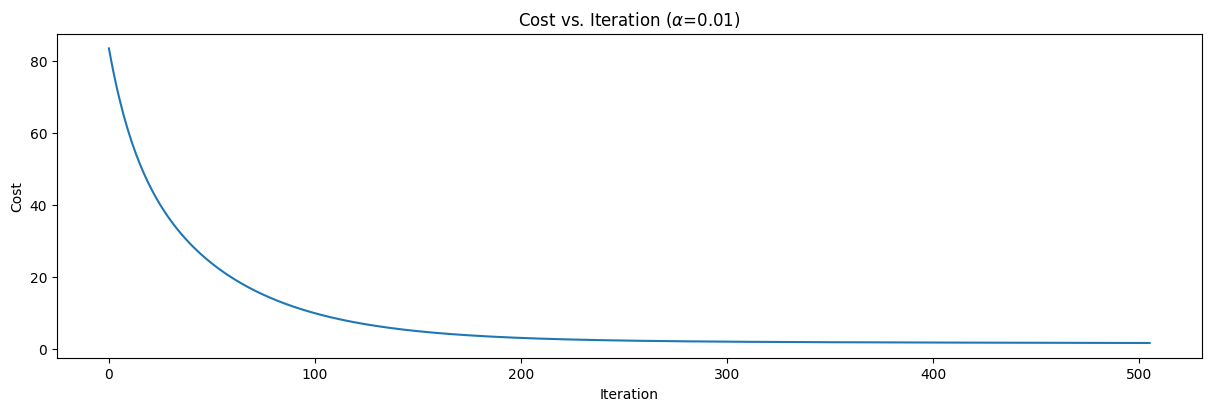

Parameters = [10.673546    1.2329392   3.37260806 -0.22440227  1.5772546   1.49970309
 -0.10644766 -0.33165355 -0.60209867]
Learning rate = 0.01
Iterations = 506
Last cost = 1.5880607570406866


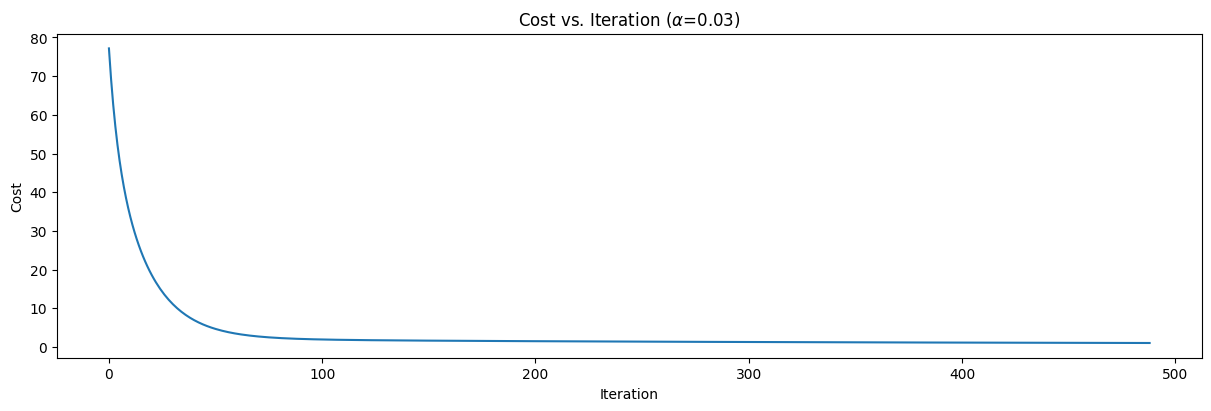

Parameters = [10.7393113   0.47598503  5.29960343  0.49595155  1.24303309  1.18023368
 -0.14316263 -0.11409247 -0.30908389]
Learning rate = 0.03
Iterations = 489
Last cost = 1.0354613264378556


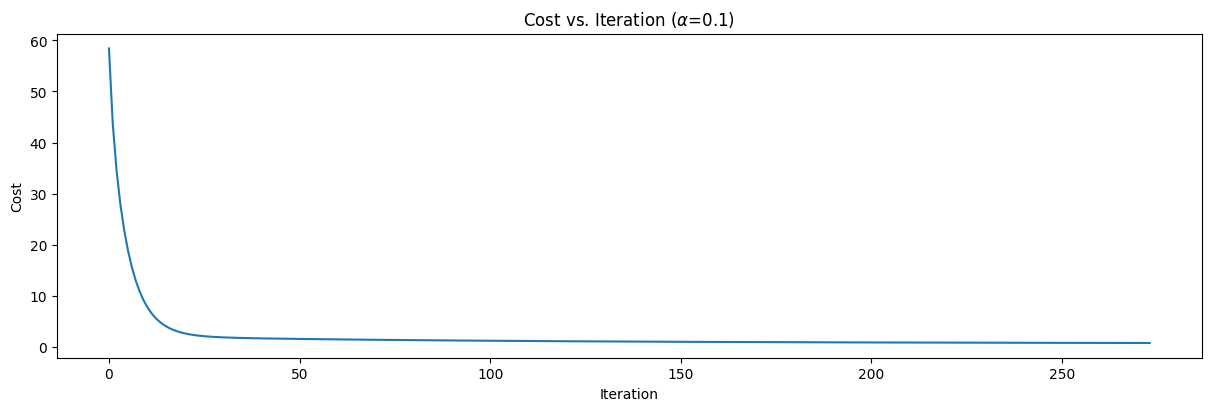

Parameters = [ 1.07393148e+01  3.71832139e-02  6.79141762e+00  9.48132441e-01
  7.60241104e-01  8.74089814e-01 -1.83837303e-01  8.06248100e-03
 -3.40970735e-03]
Learning rate = 0.1
Iterations = 274
Last cost = 0.7898025813227145


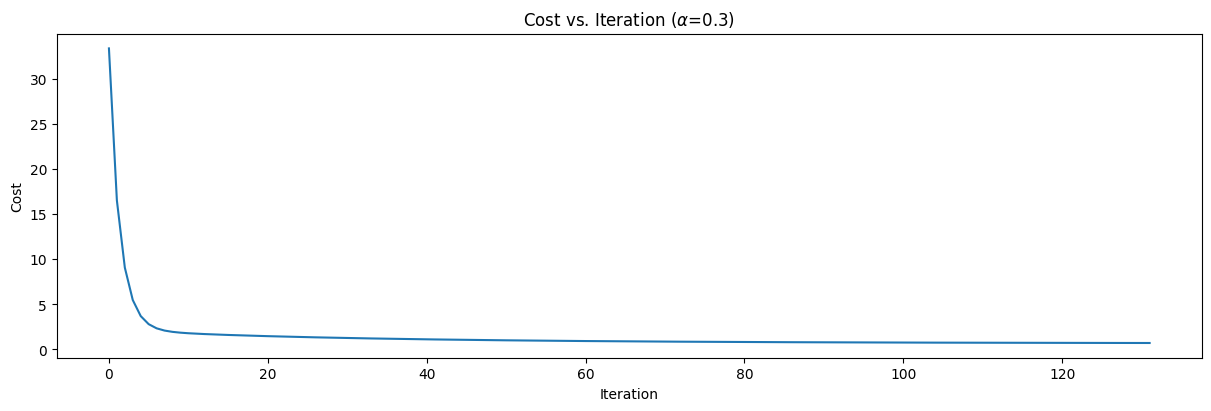

Parameters = [10.73931485 -0.12309663  7.59632265  1.19004802  0.45570442  0.66629661
 -0.23360452  0.0417054   0.19837872]
Learning rate = 0.3
Iterations = 132
Last cost = 0.71545968692263


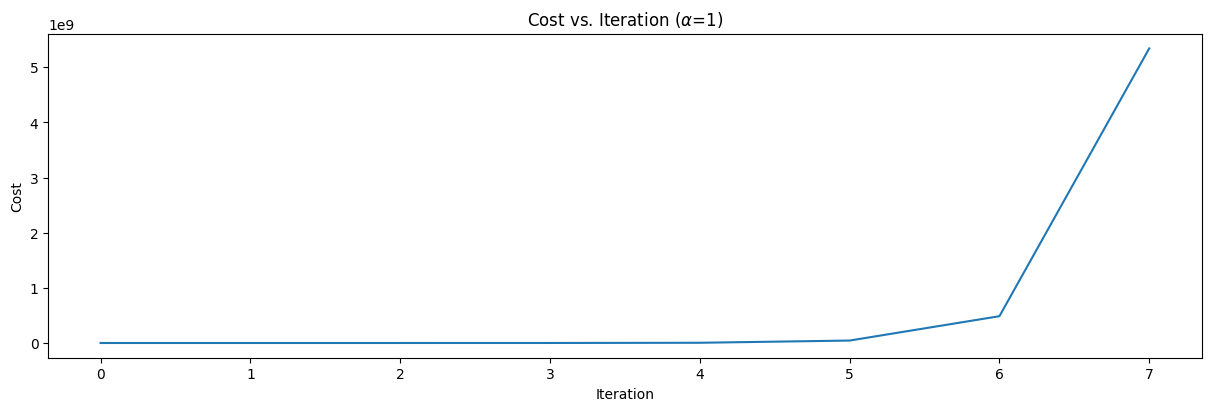

Parameters = [ 1.07393148e+01  7.30755262e+04  7.56413321e+04 -7.06557256e+04
  7.06500431e+04  7.15299370e+04  1.93841639e+04 -8.57267743e+01
  2.61177886e+04]
Learning rate = 1
Iterations = 8
Last cost = 58733227023.37588


In [45]:
standard_training_results, best_result = train_over_alphas(
    X_train=get_X(scaled_features["standard"]),
    y_train=get_y(labels),
    alphas=LEARNING_RATES
)

best_results["standard"] = best_result

for res in standard_training_results:
  plot_cost_vs_iteration(cost_history=res.cost_history, iters=res.iters, alpha=res.alpha)
  print(res)

In [46]:
best_results["standard"]

Parameters = [10.73931485 -0.12309663  7.59632265  1.19004802  0.45570442  0.66629661
 -0.23360452  0.0417054   0.19837872]
Learning rate = 0.3
Iterations = 132
Last cost = 0.71545968692263

## Model Instance Selection

We select the best performing model from the pool of candidate models trained using different training rates and differently scaled features.
The models with the lowest MSE with respect to each scaled feature set has already been determined. From them, we choose the one that minimizes MSE over the training set.

In [47]:
bestest_result = min(
    list(best_results.items()),
    key=lambda best_result: best_result[1].cost_history[-1]
)

bestest_result

('standard',
 Parameters = [10.73931485 -0.12309663  7.59632265  1.19004802  0.45570442  0.66629661
  -0.23360452  0.0417054   0.19837872]
 Learning rate = 0.3
 Iterations = 132
 Last cost = 0.71545968692263)

The best model is the one we trained over features scaled with standard scaling (z-score normalization) and learned with alpha = 0.3.

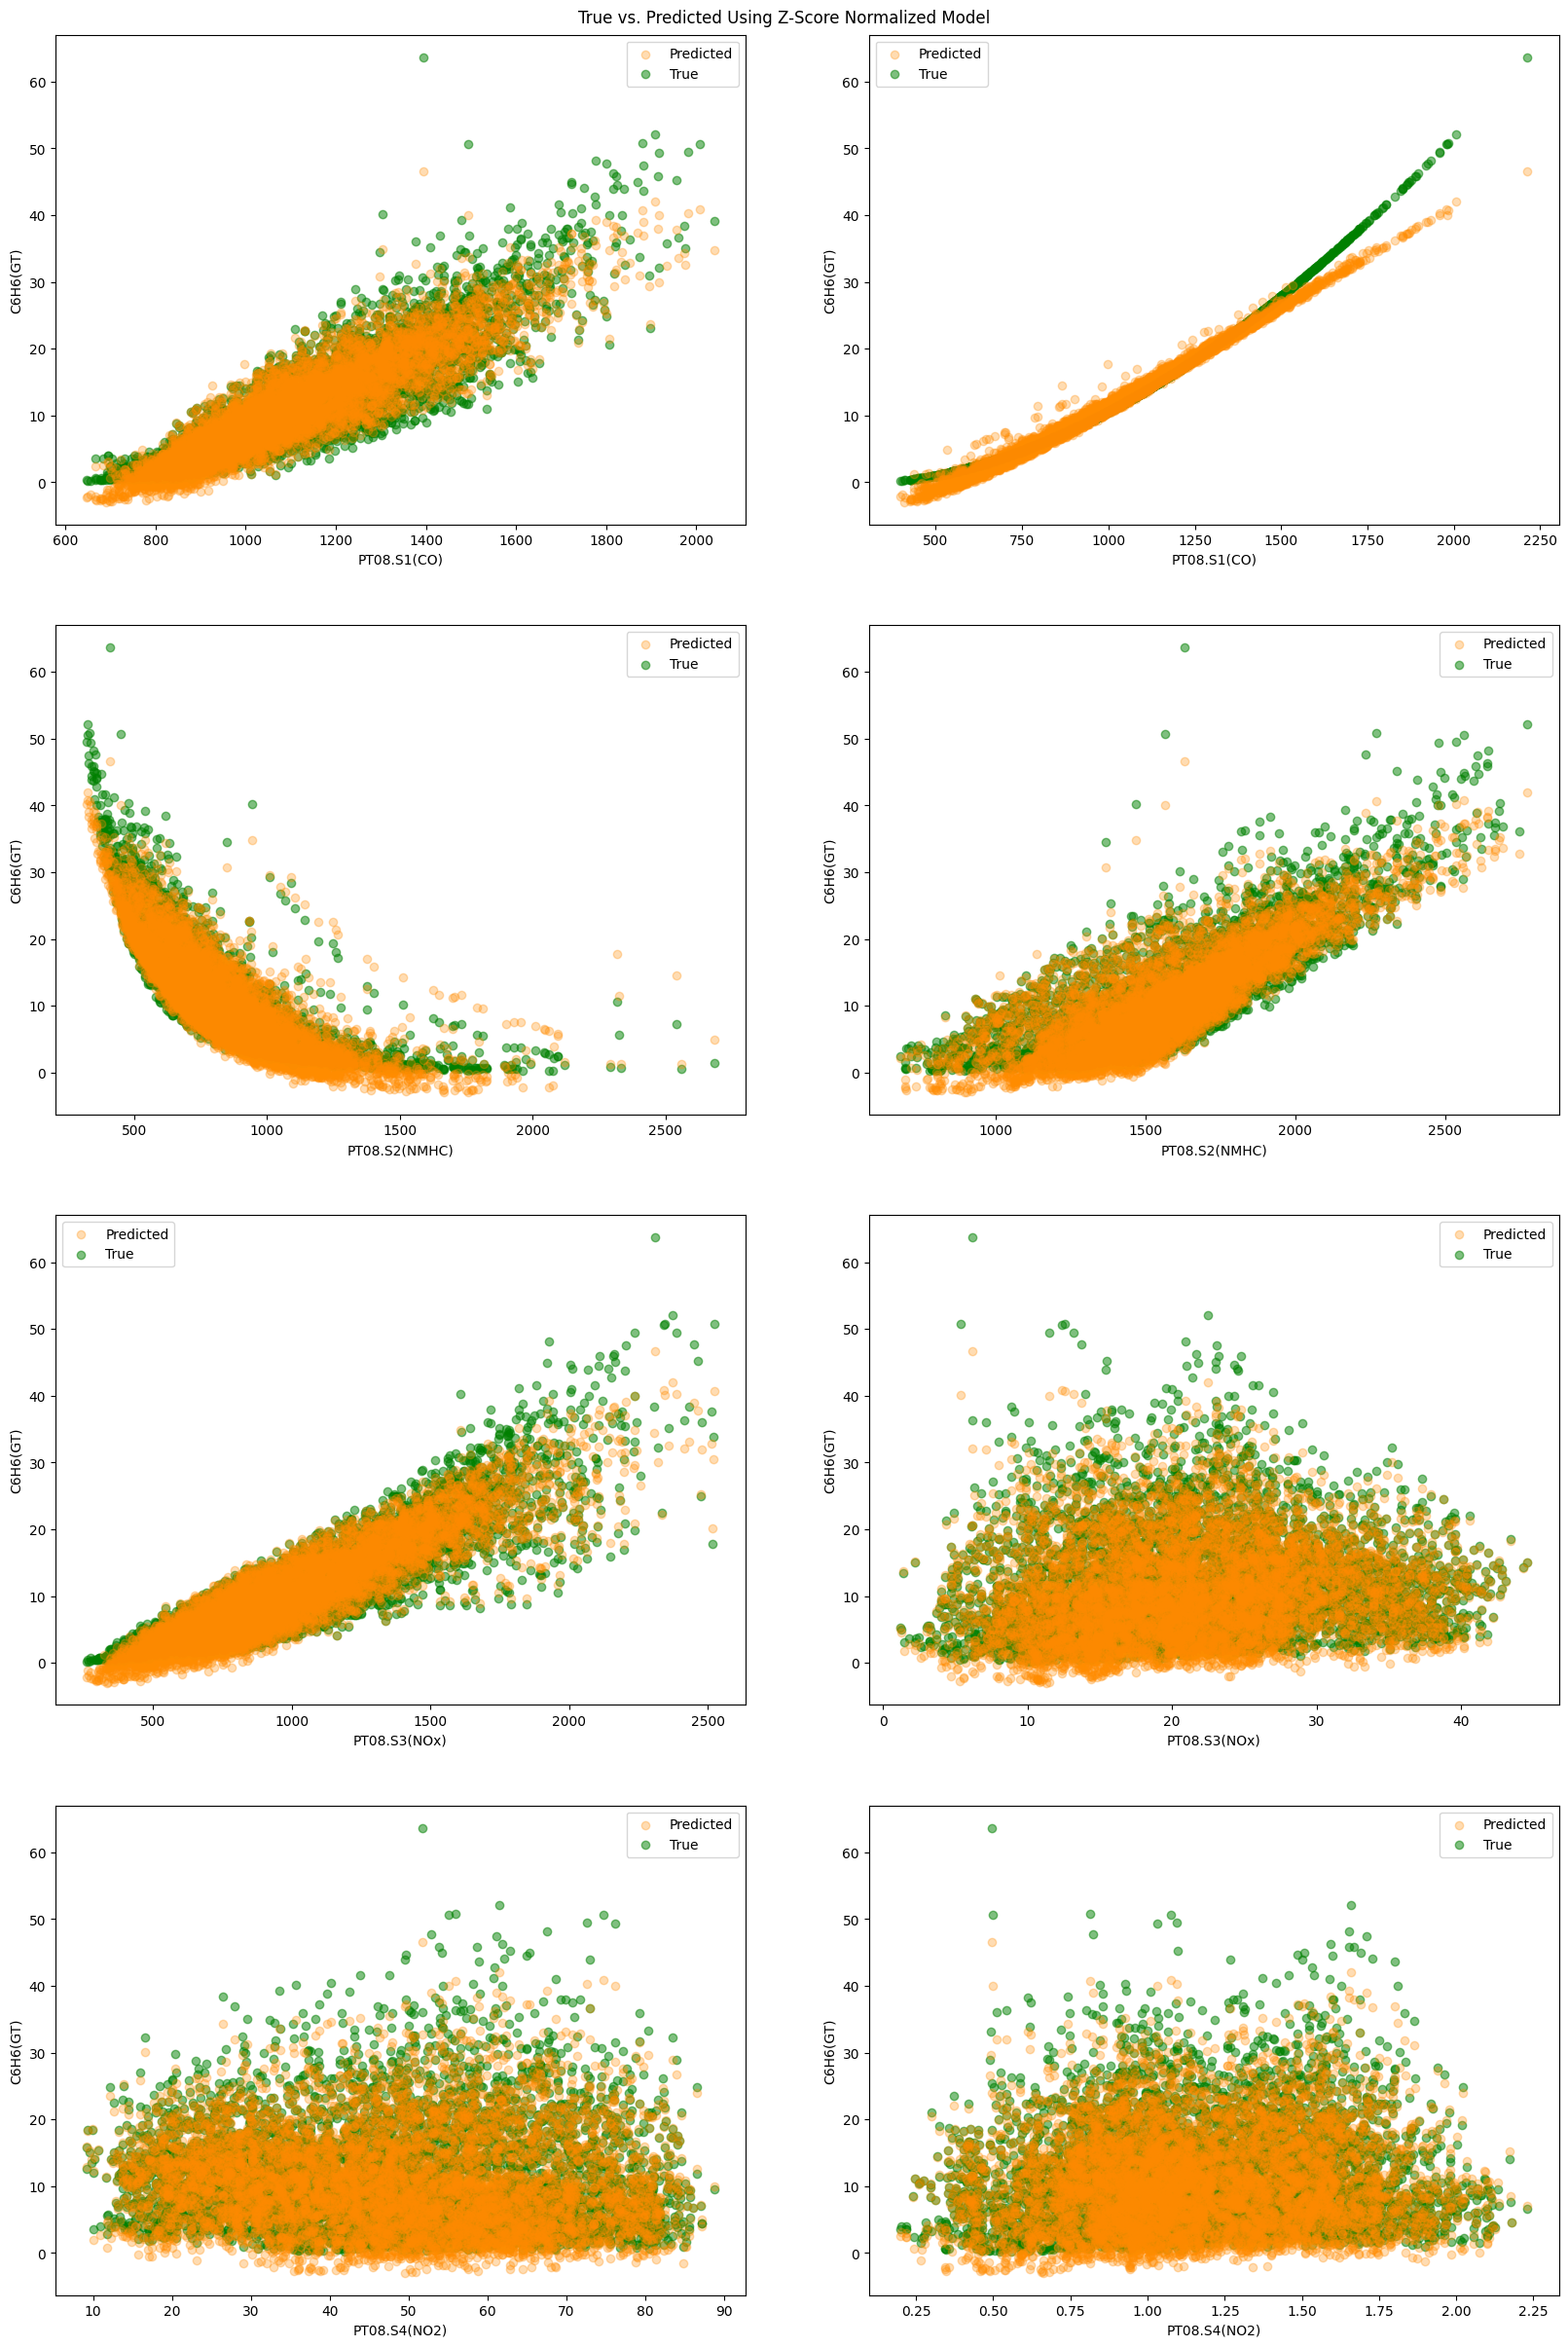

In [48]:
selected_model_parameters = bestest_result[1].theta

scatter_ytrue_vs_ypred_over_features(
    y_true=get_y(labels),
    y_pred=compute_hypothesis(
        get_X(scaled_features["standard"]),
        selected_model_parameters,
    ),
    X=get_X(training_set[selected_features]),
    label_name=label_name,
    feature_names=selected_features
)

## Testing

After choosing the best performing model instance, we proceed to testing this model over the test set.
Before testing, we preprocess the test set in the same way as we did with the training set.

In [49]:
X_test = get_X(
    preprocess_data(test_set, scaler_choice="standard")
)
y_test = get_y(test_set[label_name])

Let's test.

In [50]:
mse = compute_mse(selected_model_parameters, X_test, y_test)

print(f"MSE: {mse}")

MSE: 1.5099786722146875


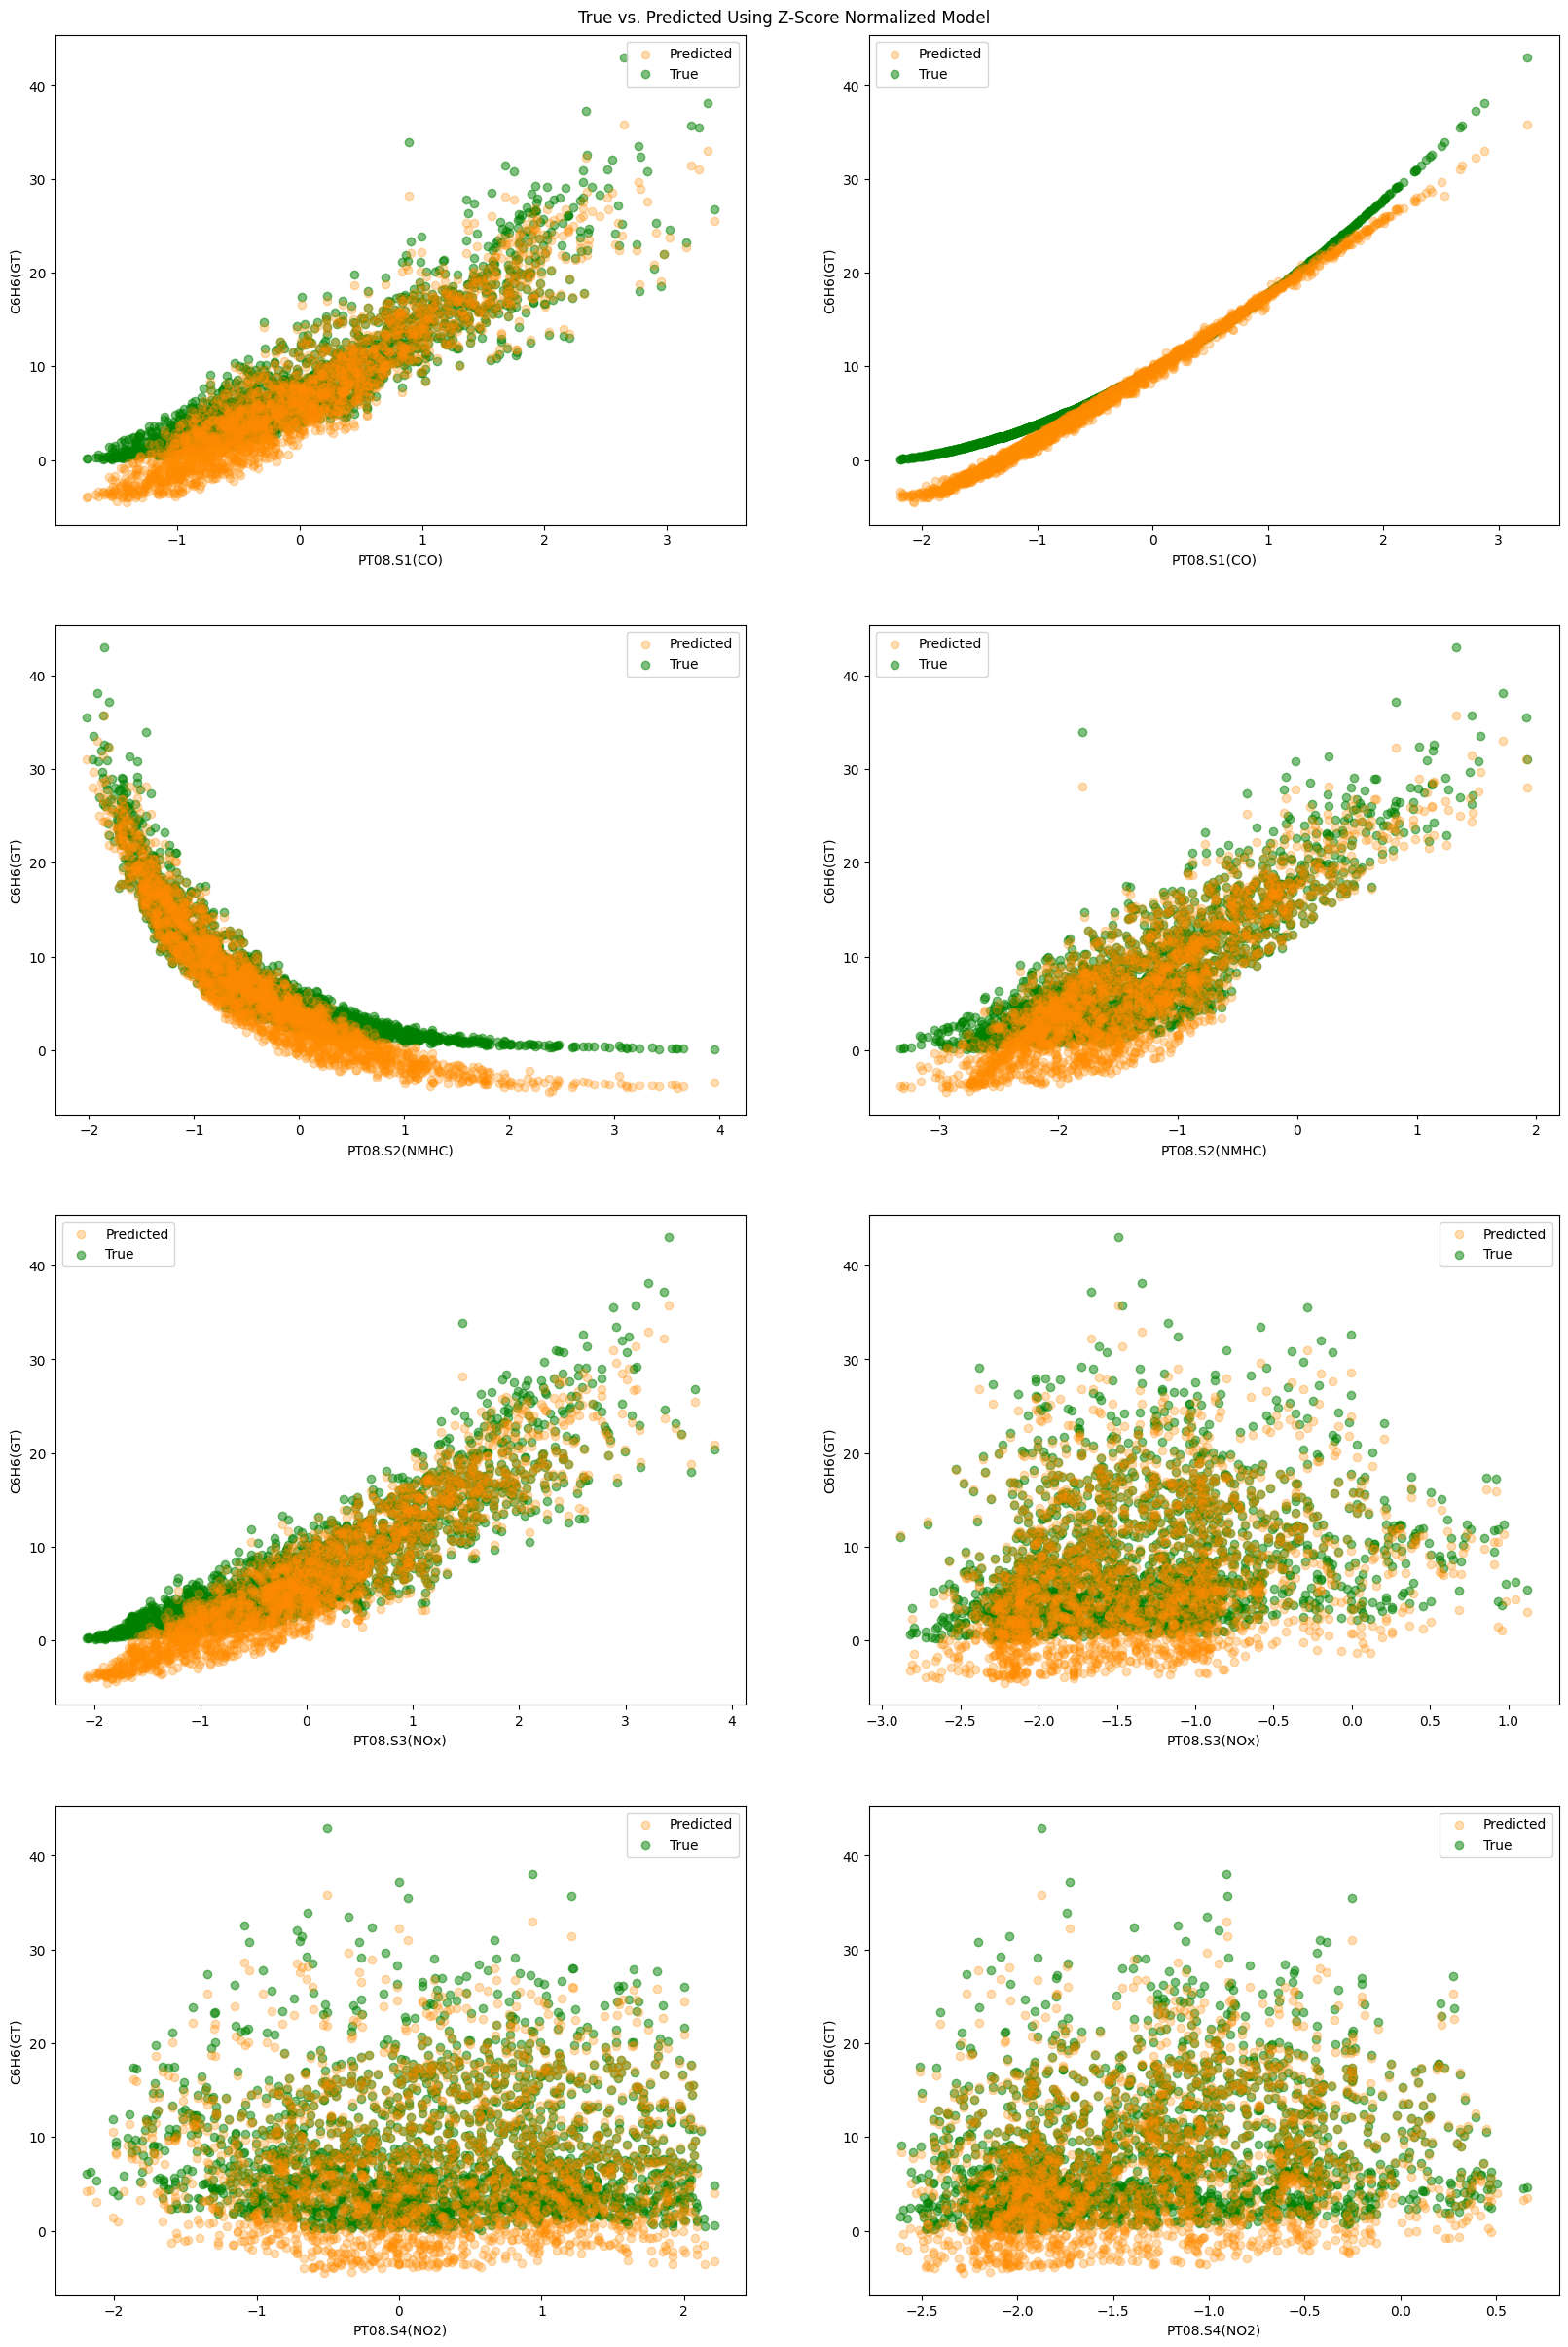

In [51]:
scatter_ytrue_vs_ypred_over_features(
    y_true=y_test,
    y_pred=compute_hypothesis(X_test, selected_model_parameters),
    X=X_test,
    label_name=label_name,
    feature_names=selected_features
)

## Downloading Preprocessed Dataset

In [56]:
preprocessed_training_dataset = preprocess_data(training_set)
preprocessed_training_dataset[label_name] = training_set[label_name]
preprocessed_training_dataset
preprocessed_training_dataset.to_csv("preprocessed_training_dataset.csv", index=False)

In [57]:
preprocessed_test_dataset = preprocess_data(test_set)
preprocessed_test_dataset[label_name] = test_set[label_name]
preprocessed_test_dataset
preprocessed_test_dataset.to_csv("preprocessed_test_dataset.csv", index=False)